# Data import testing and bot building 

- Bots will be a class
- Each bot manages a portfolio 
- Bots talk 
- Bots share resources
- Sharing of resources is balanced globally
- Buy and sell decisions are local to bots 
- Couplings between bots are based on informational coupling of stocks (Transfer Entropy)

To Do 
- [ ] Import data 
- [ ] Transfer entropy between stocks, see if this makes graph
- [ ] Build proto-bot class
- [ ] Build portofolio 
- [ ] Bot manage with portfolio


In [19]:
import yfinance as yf
import pandas as pd
import schedule
import time
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler

In [20]:
# Function to fetch and update stock data
# Function to fetch and update stock data
def fetch_stock_data(ticker, period='1d', interval='1m'):
    print(f"Fetching data for {ticker}...")
    stock = yf.Ticker(ticker)
    
    # Fetch the historical stock data
    data = stock.history(period=period, interval=interval)
    
    # Ensure the Datetime index is in proper format
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)
    
    # Save or update the data in a CSV file
    filename = f"{ticker}_historical_data.csv"
    try:
        # Append new data to existing CSV
        existing_data = pd.read_csv(filename, index_col='Datetime', parse_dates=True)
        combined_data = pd.concat([existing_data, data]).drop_duplicates()
        combined_data.to_csv(filename, index=True)  # Ensure index=True here
    except FileNotFoundError:
        # Create a new CSV file if it doesn't exist
        data.to_csv(filename, index=True)  # Ensure index=True here
    
    print(f"Data for {ticker} updated and saved to {filename}")
    
    
    
def schedule_updates_and_plot(ticker, interval_minutes=30):
    filename = f"{ticker}_historical_data.csv"

    # Fetch the initial stock data
    fetch_stock_data(ticker)
    
    # Plot the initial data
    plot_stock_data(filename)
    
    # Monitor the CSV file for updates and refresh the plot
    monitor_and_update_plot(filename, plot_stock_data)
    
    # Schedule regular updates
    schedule.every(interval_minutes).minutes.do(fetch_stock_data, ticker)
    
    while True:
        schedule.run_pending()
        time.sleep(1)
        
      
# Function to plot the stock data from the CSV
def plot_stock_data(csv_file):
    # Read the data from the CSV file using the 'Datetime' column as the index
    data = pd.read_csv(csv_file, index_col='Datetime', parse_dates=True)  # Use 'Datetime' here
    
    # Check if the data is empty or 'Datetime' column is missing
    if data.empty:
        print("No data to plot.")
        return
    
    # Plot the stock price
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Close'], label='Close Price')
    plt.title('Stock Price Over Time')
    plt.xlabel('Datetime')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
# Function to update the plot when CSV file changes
class CSVFileChangeHandler(FileSystemEventHandler):
    def __init__(self, csv_file, plot_func):
        self.csv_file = csv_file
        self.plot_func = plot_func

    def on_modified(self, event):
        if event.src_path.endswith(self.csv_file):
            print(f"{self.csv_file} has been modified. Updating plot...")
            plt.clf()  # Clear the previous plot
            self.plot_func(self.csv_file)  # Re-plot with updated data

# Function to monitor the CSV file for changes and update the plot
def monitor_and_update_plot(csv_file, plot_func):
    # Start the observer to monitor the CSV file
    event_handler = CSVFileChangeHandler(csv_file, plot_func)
    observer = Observer()
    observer.schedule(event_handler, path='.', recursive=False)
    observer.start()

    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        observer.stop()
    observer.join()


Fetching data for AAPL...
Data for AAPL updated and saved to AAPL_historical_data.csv


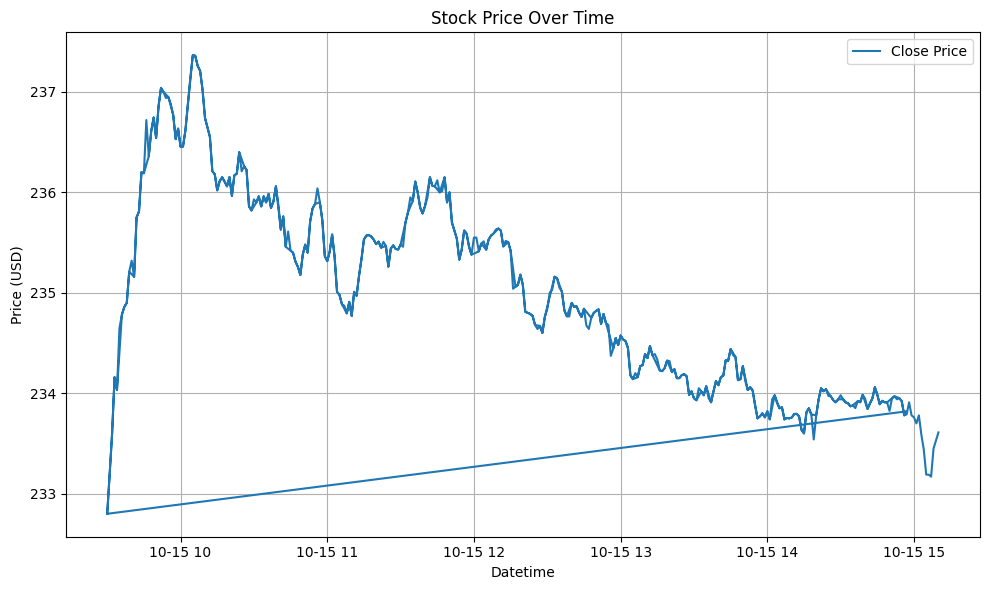

In [ ]:
# Set the stock ticker and interval for updates
ticker_symbol = 'AAPL'  # Example: Apple stock
fetch_interval_minutes = 30  # Set the update interval to 30 minutes

# Run the update and plot monitoring function
schedule_updates_and_plot(ticker_symbol, fetch_interval_minutes)